In [53]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import interp1d
from matplotlib.colors import Normalize

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 250
plt.rcParams['figure.frameon'] = False
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['image.origin'] = 'lower'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Predictions with eCad (Figure 2)

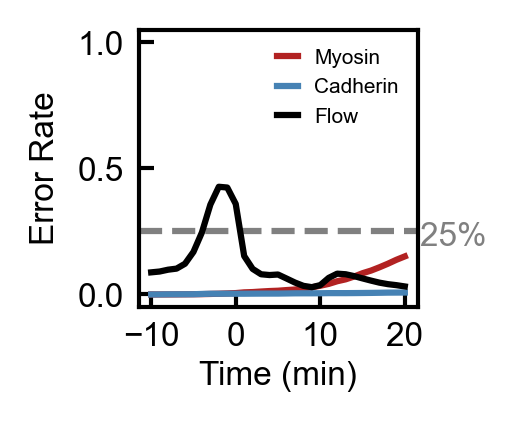

In [54]:
data = np.load('predictions/eCadControl.npz')

#Define mask that crops anterior/posterior poles
mask = np.s_[..., 15:-15, 15:-15]

def residual(u, v):
    c = np.prod(u.shape) // (u.shape[0] * u.shape[-2] * u.shape[-1])
    u = u[mask].reshape([u.shape[0], c, -1])
    v = v[mask].reshape(u.shape)
    
    u2 = np.power(u, 2).sum(axis=1)
    v2 = np.power(v, 2).sum(axis=1)
    uavg = u2.mean(axis=1, keepdims=True)
    vavg = v2.mean(axis=1, keepdims=True)
        
    res = uavg * v2 + vavg * u2 - 2 * np.sqrt(uavg * vavg) * np.einsum('bix,bix->bx', u, v)
    res = res / (2 * uavg * vavg)
    
    return res.mean(axis=1)

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(1.2, 1.2))

ax.plot(data['t'], residual(data['m0'], data['m']), color='firebrick', label='Myosin')
ax.plot(data['t'], residual(data['s0'], data['s']), color='steelblue', label='Cadherin')
ax.plot(data['t'], residual(data['v0'], data['v']), color='black', label='Flow')

ax.axhline(0.25, zorder=0, color='grey', linestyle='--')
ax.text(1.01, 0.25, '25%', transform=ax.transAxes,
        color='grey', va='center', ha='left')
ax.set_ylabel('Error Rate', labelpad=4)
ax.set_ylim([-0.05, 1.05])
ax.set_yticks([0, 0.5, 1])
ax.set_xlabel('Time (min)', labelpad=2)
ax.set_xticks([-10, 0, 10, 20])
ax.legend(fontsize=5)

fig.savefig('figures/eCadErrorRate.svg', bbox_inches='tight')

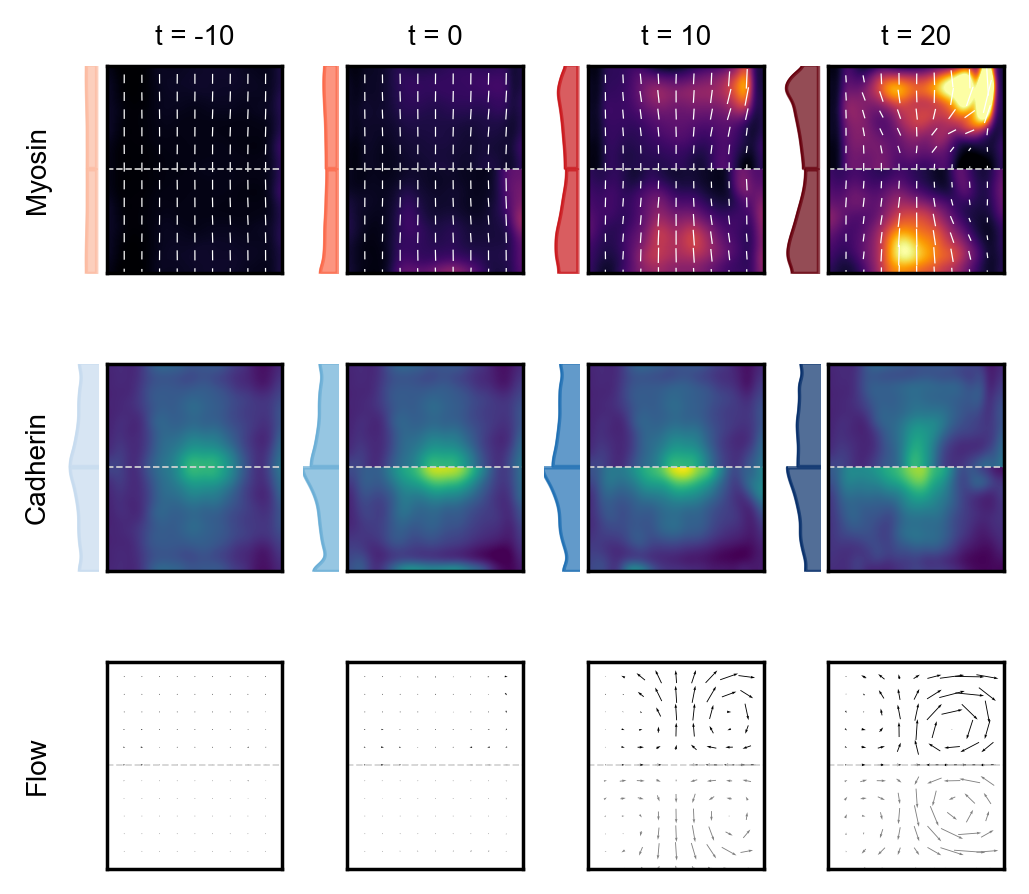

In [55]:
from morphogenesis.plot_utils import plot_scalar, plot_vector, plot_tensor
from morphogenesis.plot_utils import dv_min, dv_max, dv_midpoint, ap_min, ap_max

def get_cut(z, N0=50, N1=150):
    '''
    Return the average DV cut between N0 and N1 along the AP axi
    '''
    znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
    base = np.ones_like(znorm)
    base[np.isnan(znorm)] = 0
    znorm = np.nan_to_num(znorm)
    cut = np.sum(znorm[:, N0:N1], axis=1) / np.sum(base[:, N0:N1], axis=1)
    return cut

time = data['t']
inputs  = [data['m'], data['s'], data['v']]
targets = [data['m0'], data['s0'], data['v0']]
labels = ['Myosin', 'Cadherin', 'Flow']
colors = ['Reds', 'Blues', 'Greys']
dt = 10

N = int(np.ceil(len(time) / dt))
n_rows = 3
fig, ax = plt.subplots(n_rows, N, 
                       figsize=(N, n_rows*1.2),
                       constrained_layout=True)

vfc = 40
skip = 20
midpoint = 118
slc = np.s_[..., ::skip, ::skip]
ylim = [dv_min, dv_max]
xlim = [ap_min, ap_max]


top = np.s_[..., midpoint:, :]
bot = np.s_[..., :midpoint, :]
vwargs = dict(pivot='middle', width=0.005)

dv = np.linspace(dv_min, dv_min+(dv_max-dv_min)/2, midpoint)

mask_in = np.zeros([236, 200])
mask_tg = np.zeros([236, 200])
mask_in[top] = 1
mask_tg[bot] = 1

X = np.linspace(ap_min, ap_max, 200)
Y = np.linspace(dv_min, dv_max, 236)
Y, X = np.meshgrid(Y, X, indexing='ij')

cuts = {}
cuts0 = {}

for i, (label, z, z0) in enumerate(zip(labels, inputs, targets)):
    znorm = z0.reshape([z0.shape[0], -1, *z0.shape[-2:]])
    n_channels = znorm.shape[1]
    znorm = np.linalg.norm(znorm[mask], axis=1)[..., :-20] #ignore posterior pole
    kwargs = dict(vmin=np.min(znorm), vmax=np.max(znorm))

    axes = []
    cmap = plt.get_cmap(colors[i])
    for j in range(N):
        jj = dt * j
        if i == 0:
            ax[i, j].set_title(f't = {time[jj]:.0f}')

        color = cmap((time[jj] + 20) / (time.max() + 20))

        if n_channels == 1:
            plot_scalar(ax[i, j], z[jj, ::-1], alpha=mask_in, **kwargs)
            plot_scalar(ax[i, j], z0[jj], alpha=mask_tg, **kwargs)
        elif n_channels == 4:
            zj = z[jj, :, :, ::-1].copy()
            zj[0, 1] *= -1 #Because we're inverting it
            zj[1, 0] *= -1 #Because we're inverting it
            plot_tensor(ax[i, j], zj * np.sign(mask_in), alpha=mask_in, **kwargs)
            plot_tensor(ax[i, j], z0[jj] * np.sign(mask_tg), alpha=mask_tg, **kwargs)
        elif n_channels == 2:
            vwargs['scale'] = 5e1
            ax[i, j].quiver(X[bot][slc], Y[bot][slc],
                            z0[jj, 1][bot][slc], z0[jj, 0][bot][slc],
                            color='grey', **vwargs)
            ax[i, j].quiver(X[top][slc], Y[top][slc],
                            z[jj, 1, ::-1][top][slc], -z[jj, 0, ::-1][top][slc],
                            color='black', **vwargs)

        ax[i, j].set(xlim=xlim, ylim=ylim, xticks=[], yticks=[], aspect=1)
        ax[i, j].axhline(dv_min + 0.5*(dv_max-dv_min), lw=0.5, color='lightgrey', linestyle='--')
        
        if i == n_rows - 1:
            continue
            
        cut = get_cut(z[jj, ..., ::-1, :])
        cut0 = get_cut(z0[jj])

        cut = cut[midpoint:]
        cut0 = cut0[:midpoint]
        ax_Y = ax[i, j].inset_axes([-0.25, 0, 0.2, 1], sharey=ax[i, j])
        ax_Y.plot(cut, dv+dv_midpoint, color=color, lw=0.5)
        ax_Y.fill_betweenx(dv+dv_midpoint, 0, cut, color=color, alpha=0.7)
        ax_Y.plot(cut0, dv, color=color, lw=0.5)
        ax_Y.fill_betweenx(dv, 0, cut0, color=color, alpha=0.7)
        axes.append(ax_Y)

        if label in cuts:
            cuts[label].append(cut)
            cuts0[label].append(cut0)
        else:
            cuts[label] = [cut]
            cuts0[label] = [cut0]
        
        for axis in axes:
            xl = axes[-1].get_xlim()
            if label == 'Cadherin':
                axis.set_xlim([xl[0] + 0.4 * np.ptp(xl), xl[1]]) #Emphasize gradient over baseline
            else:
                axis.set_xlim(xl)
            axis.invert_xaxis()
            axis.axis('off')

    ax[i, 0].set_ylabel(label, labelpad=16)

plt.savefig('figures/eCad_fields.svg', bbox_inches='tight')

266.832


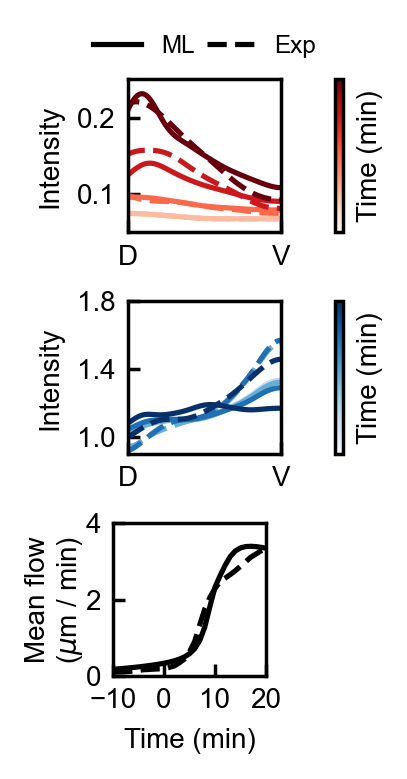

In [56]:
n_rows = 3
fig, ax = plt.subplots(n_rows, 1, 
                       figsize=(1.5, n_rows),
                       constrained_layout=True)

vfc = 40
skip = 20
midpoint = 118
slc = np.s_[..., ::skip, ::skip]
ylim = [dv_min, dv_max]
xlim = [ap_min, ap_max]

print(dv_midpoint - dv_min)


top = np.s_[..., midpoint:, :]
bot = np.s_[..., :midpoint, :]
vwargs = dict(pivot='middle', width=0.005)

dv = np.linspace(dv_min, dv_min+(dv_max-dv_min)/2, midpoint)

mask_in = np.zeros([236, 200])
mask_tg = np.zeros([236, 200])
mask_in[top] = 1
mask_tg[bot] = 1

X = np.linspace(ap_min, ap_max, 200)
Y = np.linspace(dv_min, dv_max, 236)
Y, X = np.meshgrid(Y, X, indexing='ij')


for i, (label, z, z0) in enumerate(zip(labels, inputs, targets)):
    cmap = plt.get_cmap(colors[i])
    
            
    if i == 2:
        ax[i].set_xlabel('Time (min)')
        ax[i].set_xticks([-10, 0, 10, 20])
        ax[i].set_ylabel('Mean flow\n($\\mu$m / min)', labelpad=0)
        z0norm = np.linalg.norm(
            z0.reshape([z0.shape[0], -1, *z0.shape[-2:]])[..., :-20], axis=1)
        znorm = np.linalg.norm(
            z.reshape([z.shape[0], -1, *z.shape[-2:]])[..., :-20], axis=1)
        ax[i].plot(time, z0norm.mean(axis=(-1, -2)), color='black', linestyle='--')
        ax[i].plot(time, znorm.mean(axis=(-1, -2)), color='black')
    
    else:
        for j in range(N):
            jj = dt * j

            color = cmap((time[jj] + 20) / (time.max() + 20))

            cut  = get_cut(z[jj])[:midpoint]
            cut0 = get_cut(z0[jj])[:midpoint]
            #cut = cuts[label][j]
            #cut0 = cuts0[label][j]
            
            ax[i].plot(dv-dv_min, get_cut(z[jj])[:midpoint], color=color)
            ax[i].plot(dv-dv_min, get_cut(z0[jj])[:midpoint], color=color, linestyle='--')

        ax[i].set_xlim([vfc, dv_midpoint-dv_min])
        ax[i].set_xticks([vfc, dv_midpoint-dv_min])
        ax[i].set_xticklabels(['D', 'V'])
        ax[i].set_ylabel('Intensity')
        ax[i].autoscale(axis='y')
        ax[i].set_aspect('auto')
ax[0].plot([], [], color='black', label='ML')
ax[0].plot([], [], color='black', linestyle='--', label='Exp')
ax[0].legend(ncol=2, 
             handlelength=2,
             columnspacing=0.5,
             bbox_to_anchor=[0.5, 1], 
             loc='lower center')

ax[0].set(
    ylim=[0.05, 0.25], yticks=[0.1, 0.2], aspect=(dv_midpoint-dv_min-vfc) / 0.2
)
ax[1].set(
    ylim=[0.9, 1.8], yticks=[1, 1.4, 1.8], aspect=(dv_midpoint-dv_min-vfc) / 0.9
)
ax[2].set(
    ylim=[0, 4], yticks=[0, 2, 4], 
    xlim=[-10, 20], xticks=[-10, 0, 10, 20], 
    aspect=30/4.
)

        
norm = Normalize(vmin=-20, vmax=np.max(time))
fig.subplots_adjust(right=0.92, hspace=0.4)
for i in range(n_rows-1):
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap(colors[i])),
                 ax=ax[i], label='Time (min)', ticks=[])
    
plt.savefig('figures/eCad_cuts.svg', bbox_inches='tight')

# Predictions with actin (SI Figure)

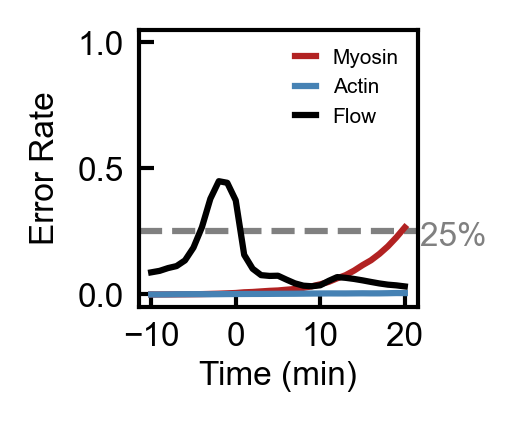

In [60]:
data = np.load('predictions/actinControl.npz')

#Define mask that crops anterior/posterior poles
mask = np.s_[..., 15:-15, 15:-15]

def residual(u, v):
    c = np.prod(u.shape) // (u.shape[0] * u.shape[-2] * u.shape[-1])
    u = u[mask].reshape([u.shape[0], c, -1])
    v = v[mask].reshape(u.shape)
    
    u2 = np.power(u, 2).sum(axis=1)
    v2 = np.power(v, 2).sum(axis=1)
    uavg = u2.mean(axis=1, keepdims=True)
    vavg = v2.mean(axis=1, keepdims=True)
        
    res = uavg * v2 + vavg * u2 - 2 * np.sqrt(uavg * vavg) * np.einsum('bix,bix->bx', u, v)
    res = res / (2 * uavg * vavg)
    
    return res.mean(axis=1)

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(1.2, 1.2))

ax.plot(data['t'], residual(data['m0'], data['m']), color='firebrick', label='Myosin')
ax.plot(data['t'], residual(data['s0'], data['s']), color='steelblue', label='Actin')
ax.plot(data['t'], residual(data['v0'], data['v']), color='black', label='Flow')

ax.axhline(0.25, zorder=0, color='grey', linestyle='--')
ax.text(1.01, 0.25, '25%', transform=ax.transAxes,
        color='grey', va='center', ha='left')
ax.set_ylabel('Error Rate', labelpad=4)
ax.set_ylim([-0.05, 1.05])
ax.set_yticks([0, 0.5, 1])
ax.set_xlabel('Time (min)', labelpad=2)
ax.set_xticks([-10, 0, 10, 20])
ax.legend(fontsize=5)

fig.savefig('figures/actinErrorRate.svg', bbox_inches='tight')

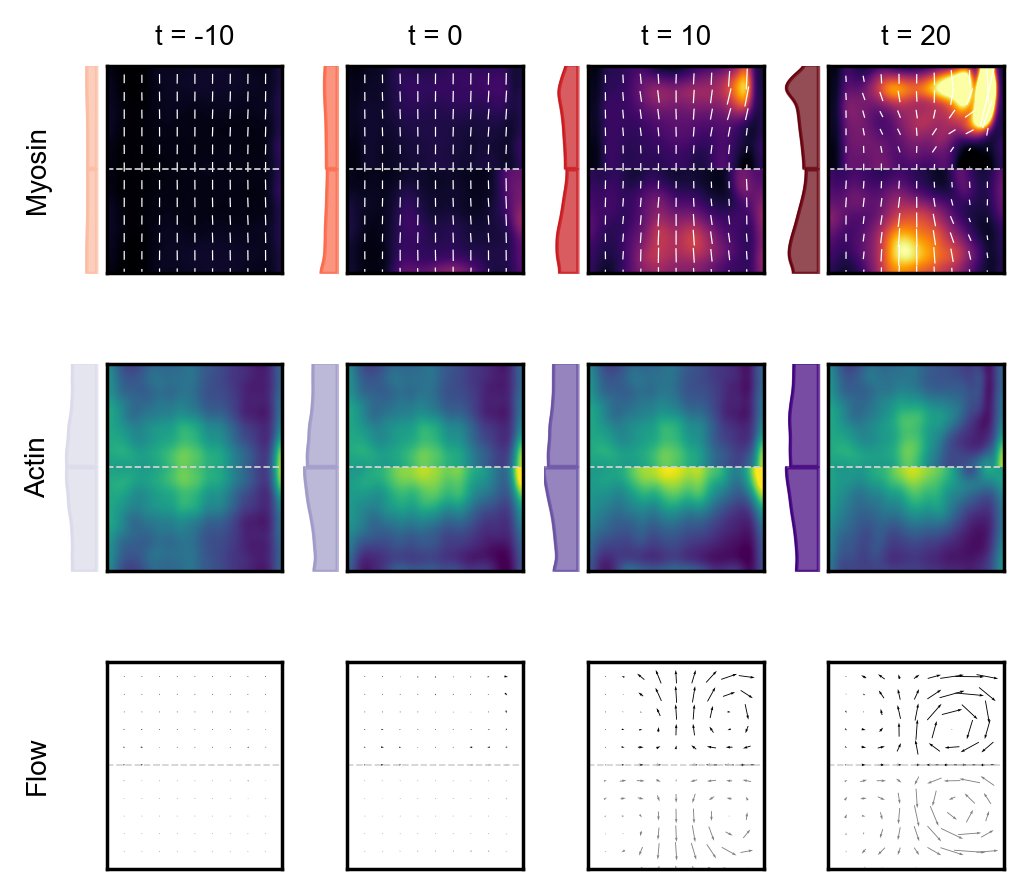

In [64]:
from morphogenesis.plot_utils import plot_scalar, plot_vector, plot_tensor
from morphogenesis.plot_utils import dv_min, dv_max, dv_midpoint, ap_min, ap_max

def get_cut(z, N0=50, N1=150):
    '''
    Return the average DV cut between N0 and N1 along the AP axi
    '''
    znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
    base = np.ones_like(znorm)
    base[np.isnan(znorm)] = 0
    znorm = np.nan_to_num(znorm)
    cut = np.sum(znorm[:, N0:N1], axis=1) / np.sum(base[:, N0:N1], axis=1)
    return cut

time = data['t']
inputs  = [data['m'], data['s'], data['v']]
targets = [data['m0'], data['s0'], data['v0']]
labels = ['Myosin', 'Actin', 'Flow']
colors = ['Reds', 'Purples', 'Greys']
dt = 10

N = int(np.ceil(len(time) / dt))
n_rows = 3
fig, ax = plt.subplots(n_rows, N, 
                       figsize=(N, n_rows*1.2),
                       constrained_layout=True)

vfc = 40
skip = 20
midpoint = 118
slc = np.s_[..., ::skip, ::skip]
ylim = [dv_min, dv_max]
xlim = [ap_min, ap_max]


top = np.s_[..., midpoint:, :]
bot = np.s_[..., :midpoint, :]
vwargs = dict(pivot='middle', width=0.005)

dv = np.linspace(dv_min, dv_min+(dv_max-dv_min)/2, midpoint)

mask_in = np.zeros([236, 200])
mask_tg = np.zeros([236, 200])
mask_in[top] = 1
mask_tg[bot] = 1

X = np.linspace(ap_min, ap_max, 200)
Y = np.linspace(dv_min, dv_max, 236)
Y, X = np.meshgrid(Y, X, indexing='ij')

cuts = {}
cuts0 = {}

for i, (label, z, z0) in enumerate(zip(labels, inputs, targets)):
    znorm = z0.reshape([z0.shape[0], -1, *z0.shape[-2:]])
    n_channels = znorm.shape[1]
    znorm = np.linalg.norm(znorm[mask], axis=1)[..., :-20] #ignore posterior pole
    kwargs = dict(vmin=np.min(znorm), vmax=np.max(znorm))

    axes = []
    cmap = plt.get_cmap(colors[i])
    for j in range(N):
        jj = dt * j
        if i == 0:
            ax[i, j].set_title(f't = {time[jj]:.0f}')

        color = cmap((time[jj] + 20) / (time.max() + 20))

        if n_channels == 1:
            plot_scalar(ax[i, j], z[jj, ::-1], alpha=mask_in, **kwargs)
            plot_scalar(ax[i, j], z0[jj], alpha=mask_tg, **kwargs)
        elif n_channels == 4:
            zj = z[jj, :, :, ::-1].copy()
            zj[0, 1] *= -1 #Because we're inverting it
            zj[1, 0] *= -1 #Because we're inverting it
            plot_tensor(ax[i, j], zj * np.sign(mask_in), alpha=mask_in, **kwargs)
            plot_tensor(ax[i, j], z0[jj] * np.sign(mask_tg), alpha=mask_tg, **kwargs)
        elif n_channels == 2:
            vwargs['scale'] = 5e1
            ax[i, j].quiver(X[bot][slc], Y[bot][slc],
                            z0[jj, 1][bot][slc], z0[jj, 0][bot][slc],
                            color='grey', **vwargs)
            ax[i, j].quiver(X[top][slc], Y[top][slc],
                            z[jj, 1, ::-1][top][slc], -z[jj, 0, ::-1][top][slc],
                            color='black', **vwargs)

        ax[i, j].set(xlim=xlim, ylim=ylim, xticks=[], yticks=[], aspect=1)
        ax[i, j].axhline(dv_min + 0.5*(dv_max-dv_min), lw=0.5, color='lightgrey', linestyle='--')
        
        if i == n_rows - 1:
            continue
            
        cut = get_cut(z[jj, ..., ::-1, :])
        cut0 = get_cut(z0[jj])

        cut = cut[midpoint:]
        cut0 = cut0[:midpoint]
        ax_Y = ax[i, j].inset_axes([-0.25, 0, 0.2, 1], sharey=ax[i, j])
        ax_Y.plot(cut, dv+dv_midpoint, color=color, lw=0.5)
        ax_Y.fill_betweenx(dv+dv_midpoint, 0, cut, color=color, alpha=0.7)
        ax_Y.plot(cut0, dv, color=color, lw=0.5)
        ax_Y.fill_betweenx(dv, 0, cut0, color=color, alpha=0.7)
        axes.append(ax_Y)

        if label in cuts:
            cuts[label].append(cut)
            cuts0[label].append(cut0)
        else:
            cuts[label] = [cut]
            cuts0[label] = [cut0]
        
        for axis in axes:
            xl = axes[-1].get_xlim()
            if label == 'Cadherin':
                axis.set_xlim([xl[0] + 0.4 * np.ptp(xl), xl[1]]) #Emphasize gradient over baseline
            else:
                axis.set_xlim(xl)
            axis.invert_xaxis()
            axis.axis('off')

    ax[i, 0].set_ylabel(label, labelpad=16)

plt.savefig('figures/actin_fields.svg', bbox_inches='tight')

266.832


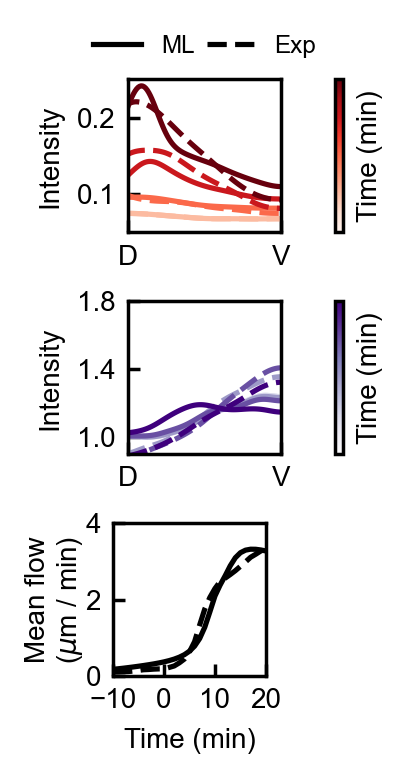

In [65]:
n_rows = 3
fig, ax = plt.subplots(n_rows, 1, 
                       figsize=(1.5, n_rows),
                       constrained_layout=True)

vfc = 40
skip = 20
midpoint = 118
slc = np.s_[..., ::skip, ::skip]
ylim = [dv_min, dv_max]
xlim = [ap_min, ap_max]

print(dv_midpoint - dv_min)


top = np.s_[..., midpoint:, :]
bot = np.s_[..., :midpoint, :]
vwargs = dict(pivot='middle', width=0.005)

dv = np.linspace(dv_min, dv_min+(dv_max-dv_min)/2, midpoint)

mask_in = np.zeros([236, 200])
mask_tg = np.zeros([236, 200])
mask_in[top] = 1
mask_tg[bot] = 1

X = np.linspace(ap_min, ap_max, 200)
Y = np.linspace(dv_min, dv_max, 236)
Y, X = np.meshgrid(Y, X, indexing='ij')


for i, (label, z, z0) in enumerate(zip(labels, inputs, targets)):
    cmap = plt.get_cmap(colors[i])
    
            
    if i == 2:
        ax[i].set_xlabel('Time (min)')
        ax[i].set_xticks([-10, 0, 10, 20])
        ax[i].set_ylabel('Mean flow\n($\\mu$m / min)', labelpad=0)
        z0norm = np.linalg.norm(
            z0.reshape([z0.shape[0], -1, *z0.shape[-2:]])[..., :-20], axis=1)
        znorm = np.linalg.norm(
            z.reshape([z.shape[0], -1, *z.shape[-2:]])[..., :-20], axis=1)
        ax[i].plot(time, z0norm.mean(axis=(-1, -2)), color='black', linestyle='--')
        ax[i].plot(time, znorm.mean(axis=(-1, -2)), color='black')
    
    else:
        for j in range(N):
            jj = dt * j

            color = cmap((time[jj] + 20) / (time.max() + 20))

            cut  = get_cut(z[jj])[:midpoint]
            cut0 = get_cut(z0[jj])[:midpoint]
            #cut = cuts[label][j]
            #cut0 = cuts0[label][j]
            
            ax[i].plot(dv-dv_min, get_cut(z[jj])[:midpoint], color=color)
            ax[i].plot(dv-dv_min, get_cut(z0[jj])[:midpoint], color=color, linestyle='--')

        ax[i].set_xlim([vfc, dv_midpoint-dv_min])
        ax[i].set_xticks([vfc, dv_midpoint-dv_min])
        ax[i].set_xticklabels(['D', 'V'])
        ax[i].set_ylabel('Intensity')
        ax[i].autoscale(axis='y')
        ax[i].set_aspect('auto')
ax[0].plot([], [], color='black', label='ML')
ax[0].plot([], [], color='black', linestyle='--', label='Exp')
ax[0].legend(ncol=2, 
             handlelength=2,
             columnspacing=0.5,
             bbox_to_anchor=[0.5, 1], 
             loc='lower center')

ax[0].set(
    ylim=[0.05, 0.25], yticks=[0.1, 0.2], aspect=(dv_midpoint-dv_min-vfc) / 0.2
)
ax[1].set(
    ylim=[0.9, 1.8], yticks=[1, 1.4, 1.8], aspect=(dv_midpoint-dv_min-vfc) / 0.9
)
ax[2].set(
    ylim=[0, 4], yticks=[0, 2, 4], 
    xlim=[-10, 20], xticks=[-10, 0, 10, 20], 
    aspect=30/4.
)

        
norm = Normalize(vmin=-20, vmax=np.max(time))
fig.subplots_adjust(right=0.92, hspace=0.4)
for i in range(n_rows-1):
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap(colors[i])),
                 ax=ax[i], label='Time (min)', ticks=[])
    
plt.savefig('figures/actin_cuts.svg', bbox_inches='tight')